# Exponential Smoothing

In [214]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Data

In [215]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df["year"] = df["date"].dt.year
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df["Passengers"] = df["Passengers"].astype(float)

    return df 

df = read_dataset()
df

,Passengers,date,year
0,112.0,1949-01-01,1949
1,118.0,1949-02-01,1949
2,132.0,1949-03-01,1949
3,129.0,1949-04-01,1949
4,121.0,1949-05-01,1949
...,...,...,...
139,606.0,1960-08-01,1960
140,508.0,1960-09-01,1960
141,461.0,1960-10-01,1960
142,390.0,1960-11-01,1960


In [216]:
ts_variable = "Passengers"
date_variable = "date"

In [217]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.95)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date,year
0,112.0,1949-01-01,1949
1,118.0,1949-02-01,1949
2,132.0,1949-03-01,1949
3,129.0,1949-04-01,1949
4,121.0,1949-05-01,1949
...,...,...,...
131,405.0,1959-12-01,1959
132,417.0,1960-01-01,1960
133,391.0,1960-02-01,1960
134,419.0,1960-03-01,1960


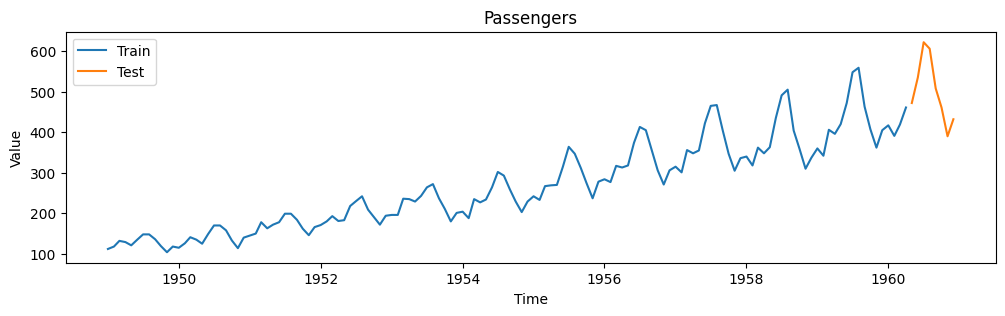

In [218]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

## Single Exponential Smoothing 

In [219]:
class SingleExponentialSmoothing():

    def __init__(self, ts_data, alpha) -> None:
        
        self.alpha = alpha
        self.ts_data = ts_data
        self.s_list = [ts_data[0]]
        
    def get_next_step(self, prev_forecast, prev_value):

        next_forecast = self.alpha * prev_value + (1 - self.alpha) * prev_forecast 

        return next_forecast 
    
    def fit_ses(self):

        for i in range(1, len(self.ts_data)):
            
            next_value = self.get_next_step(self.s_list[-1], self.ts_data[i])
            self.s_list.append(next_value)
    
    def forecast_n_steps(self, n_steps):

        forecast = [self.s_list[-1]]

        for _ in range(1, n_steps):

            next_value = self.get_next_step(forecast[-1], forecast[-1])
            forecast.append(next_value)

        return forecast 


ses_05 = SingleExponentialSmoothing(ts_data = train[ts_variable].values, alpha = 0.5)
ses_01 = SingleExponentialSmoothing(ts_data = train[ts_variable].values, alpha = 0.1)
ses_05.fit_ses() 
ses_01.fit_ses() 

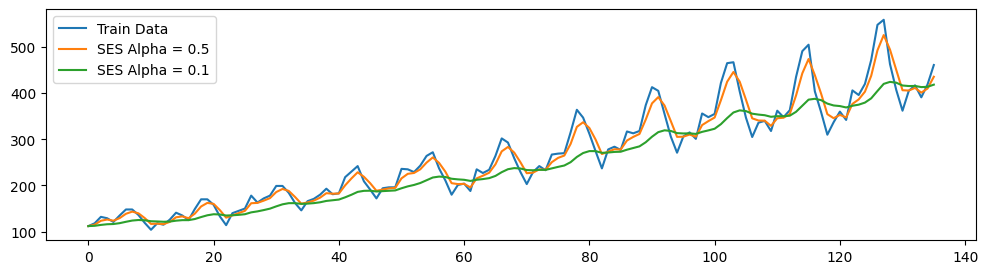

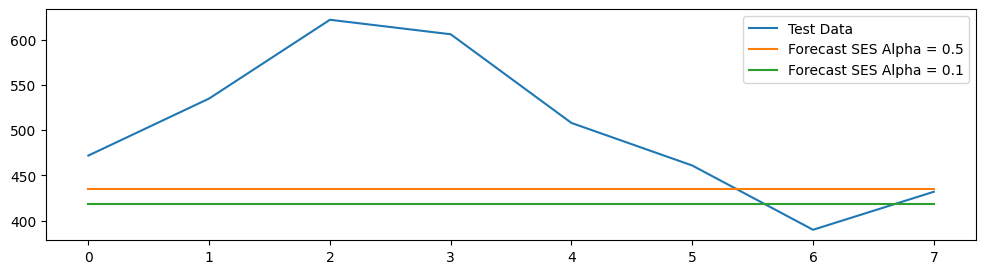

In [220]:
plt.figure(figsize=(12,3))
plt.plot(ses_05.ts_data, label = "Train Data")
plt.plot(ses_05.s_list, label = f"SES Alpha = {ses_05.alpha}")
plt.plot(ses_01.s_list, label = f"SES Alpha = {ses_01.alpha}")
plt.legend()

forecast_ses_01 = ses_01.forecast_n_steps(n_steps=len(test)) 
forecast_ses_05 = ses_05.forecast_n_steps(n_steps=len(test)) 

plt.figure(figsize=(12,3))
plt.plot(test[ts_variable].values, label = "Test Data")
plt.plot(forecast_ses_05, label = f"Forecast SES Alpha = {ses_05.alpha}")
plt.plot(forecast_ses_01, label = f"Forecast SES Alpha = {ses_01.alpha}")
plt.legend()

## Double Exponential Smoothing 

In [221]:
class DoubleExponentialSmoothing():

    def __init__(self, ts_data, alpha, beta) -> None:
        
        self.alpha = alpha
        self.beta = beta
        self.ts_data = ts_data
        self.s_list = [ts_data[0]]
        self.b_list = [ts_data[0]]
        
    def get_next_step(self, actual_value, prev_s, prev_b):

        s_t = self.alpha * actual_value + (1-self.alpha)*(prev_s + prev_b)
        
        b_t = self.beta * (s_t - prev_s) + (1 - self.beta)*prev_b 

        return s_t, b_t 
    
    def fit_des(self):

        for i in range(1, len(self.ts_data)):
            
            s_t, b_t = self.get_next_step(self.ts_data[i], self.s_list[-1], self.b_list[-1])

            self.s_list.append(s_t)
            self.b_list.append(b_t)

    def forecast_n_steps(self, n_steps):

        s_forecast = [self.s_list[-1]]
        b_forecast = [self.b_list[-1]]

        for _ in range(1, n_steps):

            s_t, b_t = self.get_next_step(s_forecast[-1], s_forecast[-1], b_forecast[-1])
            s_forecast.append(s_t)
            b_forecast.append(b_t)

        return s_forecast  

des_05 = DoubleExponentialSmoothing(alpha = 0.5, beta = 0.9, ts_data=train[ts_variable].values)
des_01 = DoubleExponentialSmoothing(alpha = 0.5, beta = 0.1, ts_data=train[ts_variable].values)
des_05.fit_des()
des_01.fit_des()

Text(0.5, 0.98, 'Single/Double Exponential Smoothing')

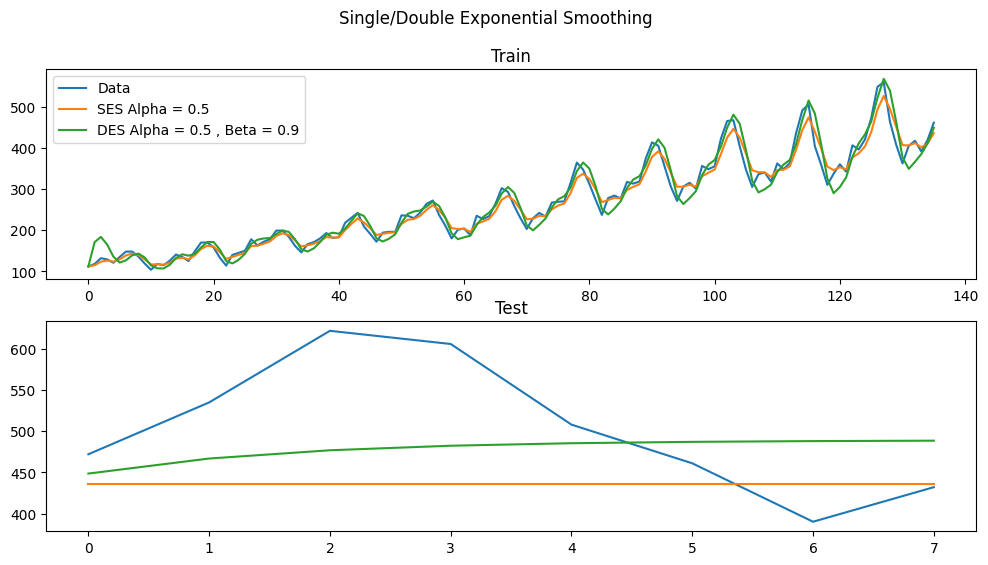

In [222]:
fig, ax = plt.subplots(2,1, figsize = (12, 6))

ax[0].plot(des_05.ts_data, label = "Data")
ax[0].plot(ses_05.s_list, label = f"SES Alpha = {des_05.alpha}")
ax[0].plot(des_05.s_list, label = f"DES Alpha = {des_05.alpha} , Beta = {des_05.beta}")
ax[0].set_title("Train")
ax[0].legend()

# Forecast
forecast_des_05 = des_05.forecast_n_steps(n_steps=len(test)) 

ax[1].plot(test[ts_variable].values)
ax[1].plot(forecast_ses_05)
ax[1].plot(forecast_des_05)
ax[1].set_title("Test")

fig.suptitle("Single/Double Exponential Smoothing")
plt.savefig("img/single_double_exponential_smoothing.png", dpi = 300, bbox_inches='tight')